# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import time
# import re
import random
import pickle
import datasets as dst

import sklearn as skl
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, auc, roc_curve, confusion_matrix


# Chargement des données et prétraitement

In [2]:
def preProcessDataframe(df: object) -> object:
    dfret = df.dropna(subset = [
        "station_id", 
        "lat", 
        "lon", 
        "occupation_prct", 
        "occupation_class"
    ]).copy()
    
    dfret['jour'] = dfret["time"].dt.day
    dfret['heure'] = dfret["time"].dt.hour
    dfret['minute'] = dfret["time"].dt.minute
    
    return dfret

In [6]:
path='F:/work/datasets/'
df0 = dst.getDataset("2023_03_17", path)
df1 = dst.getDataset("2023_03_18", path)
df2 = dst.getDataset("2023_03_19", path)
df3 = dst.getDataset("2023_03_20", path)
df4 = dst.getDataset("2023_03_21", path)
df5 = dst.getDataset("2023_03_22", path)

#Je réduis systématiquement la résolution en temps par 10 sur ce classeur
step=10
df0=df0.iloc[0::step]
df1=df1.iloc[0::step]
df2=df2.iloc[0::step]
df3=df3.iloc[0::step]
df4=df4.iloc[0::step]
df5=df5.iloc[0::step]


df0=preProcessDataframe(df0)
df1=preProcessDataframe(df1)
df2=preProcessDataframe(df2)
df3=preProcessDataframe(df3)
df4=preProcessDataframe(df4)
df5=preProcessDataframe(df5)

In [19]:
#On vérifie que prendre une ligne sur 10 laisse un meme nombre de points par station
df=df1
station_list=list(set(df.station_id))
Nst=len(station_list)
Nt=len(set(df[df['station_id'] == station_list[0]].time))
station_timeserie=np.ndarray([Nst,Nt])

foo=[]
for i in station_list : 
    foo.append(len(set(df[df['station_id'] == i]) ))
print(np.min(foo) , np.max(foo) )

22 22


In [34]:
#Ancienne version lente avec des merges
# ## Ajout de valeurs d'occupation 6h plus tot :
# def add_old_values(df, df_old=None):
#     dec=6*3 #on a une valeur toutes les 20 minutes, et on regarde 6 heures avant
    
#     if df_old is None:
#         df_main=df.copy()
#     else : 
#         df_main=pd.concat([df_old, df])
        
# #     df2=df.shift()
#     df_join=df_main[['time','station_id','occupation_prct','occupation_class']].copy()
#     df_join['time']=df_join['time']+pd.Timedelta(hours=6)
#     df_join=df_join.rename(columns={"time": "old_time", "occupation_prct": "old_occupation_prct", 
#                                     "occupation_class": "old_occupation_class"})

#     df_main=pd.merge_asof(df_main.sort_values('time'), df_join.sort_values('old_time'), 
#                           by='station_id', left_on='time', right_on='old_time', direction='nearest')
# #     df_main.drop('old_time')
    
#     df_main=df_main[df_main['jour'] == df.loc[0,'jour']]
    
    
#     return df_main


In [225]:
## Ajout de valeurs d'occupation 6h plus tot :
def add_old_values(df, df_old=None):
    dec=6*3 #on a une valeur toutes les 20 minutes, et on regarde 6 heures avant
    
    if df_old is None:
        df_main=df.copy()
    else : 
        df_main=pd.concat([df_old, df])
        
    df_main["old_occupation_class"]=df_main["occupation_class"].shift(periods=dec, axis=0)-df_main["occupation_class"].shift(periods=dec+24*3, axis=0)
    df_main["old_occupation_prct"]=df_main["occupation_prct"].shift(periods=dec, axis=0)-df_main["occupation_prct"].shift(periods=dec+24*3, axis=0)

    
    df_main=df_main[df_main['jour'] == df['jour'].median()]
    
    
    return df_main


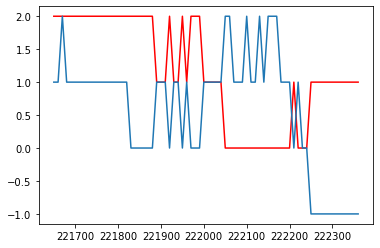

In [218]:
foo=add_old_values(df3, df2)
plt.plot(foo[foo['station_id'] == station_list[0]].occupation_class, color='r')
plt.plot(foo[foo['station_id'] == station_list[0]].old_occupation_class)

In [219]:
df5=add_old_values(df5, df4)
df4=add_old_values(df4, df3)
df3=add_old_values(df3, df2)
df2=add_old_values(df2, df1)
df1=add_old_values(df1, df0)
df0=add_old_values(df0)
df0=df0.dropna(subset=['old_occupation_prct','old_occupation_class'])

## Entrainement et prédiction

### Toutes les stations

In [11]:
df_train=pd.concat([df0,df1])
df_train=pd.concat([df_train,df2])
df_train=pd.concat([df_train,df3])
df_train=pd.concat([df_train,df4])
# df_tot=pd.concat(df_tot,df4)

df_test=df5

In [91]:
feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
feat2 = feat1+["old_occupation_class"]
target = ["occupation_class"]

x_train1=df_train[feat1]
x_train2=df_train[feat2]
y_train=df_train[target]

x_test1=df_test[feat1]
x_test2=df_test[feat2]
y_test=df_test[target]

In [93]:
clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf1.fit(x_train1, y_train.values.ravel())

clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
clf2.fit(x_train2, y_train.values.ravel())


GradientBoostingClassifier(learning_rate=1.0, max_depth=1, random_state=0)

In [94]:
y_pred1 = clf1.predict(x_test1)
y_pred2 = clf2.predict(x_test2)


In [95]:
accuracy_score(y_test, y_pred1)

0.4228224809092872

In [96]:
accuracy_score(y_test, y_pred2)

0.4221943032135215

### Une station à la fois

In [220]:
def test_one_class(df_train_in: object, df_test_in, feat_supp=[]) -> None:
    
    station=random.sample(station_list,1)[0]
    print(station)
    
    
    df_train=df_train_in[df_train_in['station_id'] == station]
    df_test=df_test_in[df_test_in['station_id'] == station]

    feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    feat2 = feat1+["old_occupation_prct", "old_occupation_class"]
    target = ["occupation_class"]

    x_train1=df_train[feat1]
    x_train2=df_train[feat2]
    y_train=df_train[target]

    x_test1=df_test[feat1]
    x_test2=df_test[feat2]
    y_test=df_test[target]

    clf1 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    clf1.fit(x_train1, y_train.values.ravel())

    clf2 = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)
    clf2.fit(x_train2, y_train.values.ravel())


    y_pred1 = clf1.predict(x_test1)
    y_pred2 = clf2.predict(x_test2)


#     print(feat)
#     print(clf.feature_importances_)

#     cm1 = confusion_matrix(y_test, y_pred1)
    
    
#     cm2 = confusion_matrix(y_test, y_pred2)

#     sns.heatmap(cm1, annot=True, cmap="Blues", fmt="g")
#     sns.heatmap(cm2, annot=True, cmap="Blues", fmt="g")    
    
#     plt.xlabel('Prédictions')
#     plt.ylabel('Valeurs réelles')
#     plt.show()
    
#     print(classification_report(y_test,y_pred1))
#     print(classification_report(y_test,y_pred2))


#     print(len(y_test),len(y_pred1),len(y_pred2))
#     print(type(y_test),len(y_pred1),len(y_pred2))

    plt.plot(y_test.values.ravel(), color='black', label='True')
    plt.plot(y_pred1, color='red', label='Pred. basic')
    plt.plot(y_pred2, color='blue', label='Pred. basic+old values')
    plt.legend()
    plt.show()

#     print(y_test.values.ravel())
#     print('\n')
#     print(y_pred1)
#     print('\n')
#     print(y_pred2)

# test_one(df_train, df_test)

82445192


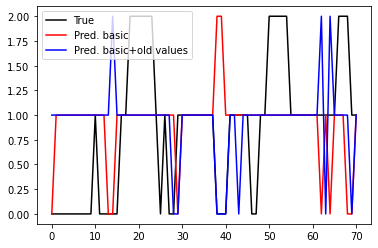

In [221]:
test_one_class(df_train, df_test)

In [222]:
def test_one_regr(df_train_in: object, df_test_in, feat_supp=[]) -> None:
    
    station=random.sample(station_list,1)[0]
    print(station)
    
    
    df_train=df_train_in[df_train_in['station_id'] == station]
    df_test=df_test_in[df_test_in['station_id'] == station]

    feat1 = ["station_id", "lon", "lat", "jour", "heure", "minute"]
    feat2 = feat1+["old_occupation_prct", "old_occupation_class"]
    target = ["occupation_prct"]

    x_train1=df_train[feat1]
    x_train2=df_train[feat2]
    y_train=df_train[target]

    x_test1=df_test[feat1]
    x_test2=df_test[feat2]
    y_test=df_test[target]

    clf1 = GradientBoostingRegressor(random_state=0)
    clf1.fit(x_train1, y_train.values.ravel())

    clf2 = GradientBoostingRegressor(random_state=0)
    clf2.fit(x_train2, y_train.values.ravel())


    y_pred1 = clf1.predict(x_test1)
    y_pred2 = clf2.predict(x_test2)

    x=df_test['time']
    
    print(x.shape, y_test.shape, y_pred1.shape)
    
    plt.figure(figsize=(16,6))
    plt.plot(x, y_test.values.ravel(), color='black', label='True')
    plt.plot(x, y_pred1, color='red', label='Pred. basic')
    plt.plot(x, y_pred2, color='blue', label='Pred. basic+old values')
    plt.legend()
    plt.show()

    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf1.feature_names_in_,
        'importance': clf1.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances : basic prediction', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()
    
    #create a dataframe with the variable importances of the model
    df_importances = pd.DataFrame({
        'feature': clf2.feature_names_in_,
        'importance': clf2.feature_importances_
    }).sort_values(by='importance', ascending=False)
    
    #plot variable importances of the model
    plt.title('Variable Importances ; basic + old values', fontsize=16)
    sns.barplot(x = df_importances.importance, y = df_importances.feature, orient='h')
    plt.show()
# test_one(df_train, df_test)

1057319366
(71,) (71, 1) (71,)


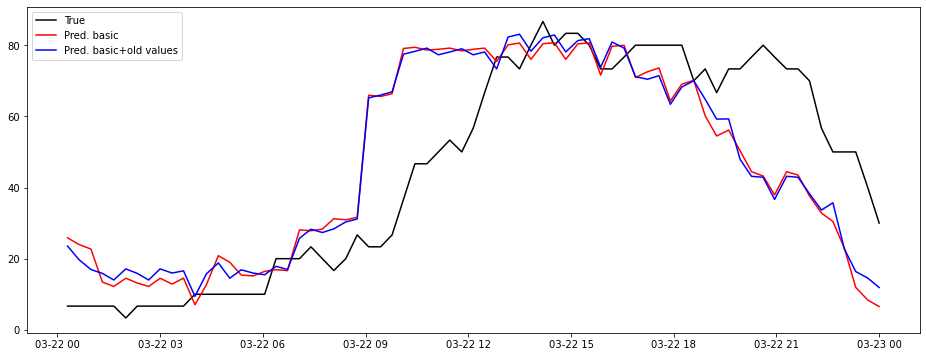

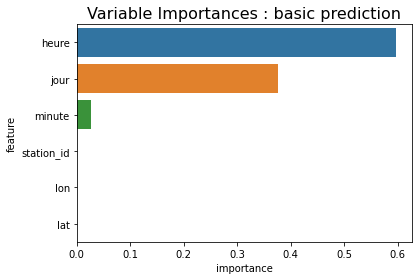

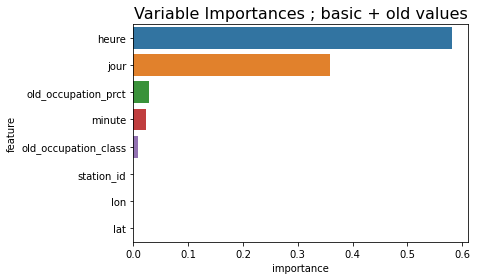

In [224]:
test_one_regr(df_train, df_test)

# Deep learning

On va essayer d'appliquer une régression par RNN ou un CNN (d'abord CNN car il y a un tutorial)

## Feature et target

On met en entrée les valeurs sur x heures avant le temps de la prédiction. Puis la prédiction est encore quelques heures après (6h par exemple).
On fait ça pour chaque temps de la journée.

Les features seront les taux d'occupation, le jour de la semaine, l'heure, l'identifiant de la station. On pourra rajouter les taux d'occupation décalés de 6 heures.

In [ ]:
#On suppose qu'on a une donnée toutes les 20 minutes
Ntrain=24*3 #On s'entraine sur chaque temps de la journée

Nt=6*3  #On regarde 6 heures avant
Nfeat=4

#Chaque input aura les formes :
# Input shape: (32, 18, 4)
# Labels shape: (32, 18, 1)
# Output shape: (32, 16, 1)

Ntrain=df_test['station_id'].count()
Ntest=df_test['station_id'].count()



# feat2 = feat1

In [65]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]


df_train_one=df_train[df_train['station_id'] == station]
df_test_one=df_test[df_test['station_id'] == station]




print(station, df_train_one.station_id.count(), df_test_one.station_id.count())

213992316 304 70


In [62]:
feat = ["station_id", "lon", "lat", "jour", "heure", "minute"]+["old_occupation_prct"]
target=["occupation_prct"]

def format_input(df, feat, target):
    
    numarr_feat_in=df[feat].to_numpy()
    numarr_targ_in=df[target].to_numpy()

    
    
#     print(numarr_in.shape)

    Nt=numarr_feat_in.shape[0]
    Nf=numarr_feat_in.shape[1]
    Ndt=24*3

    numarr_feat_out=np.ndarray([Nt-Ndt,Nf,Ndt])
    numarr_targ_out=numarr_targ_in[Ndt:]
    
    for i in range(Nt-Ndt):
        for f in range(Nf):
            numarr_feat_out[i,f,:]=numarr_feat_in[i:i+Ndt,f]
    
    
    return numarr_feat_out, numarr_targ_out
# #     df_return
#     for 

    
#     return df_ret

# x_train, y_train=format_input(df_train, feat, target)
# x_test, y_test=format_input(df_test, feat, target)
x_train, y_train=format_input(df_train_one, feat, target)
x_test, y_test=format_input(df_test_one, feat, target)

ValueError: negative dimensions are not allowed

In [200]:
station_list=list(set(df_train.station_id))
station=random.sample(station_list,1)[0]

df=pd.concat([df_train,df_test])
df_one=df[df['station_id'] == station]

# print(station, df_train_one.station_id.count(), df_test_one.station_id.count())

In [201]:
def format_input(df, feat, target):

    feat = ["station_id", "lon", "lat", "jour", "heure", "minute","old_occupation_prct"]
#     feat = ["jour", "heure", "minute"]+["old_occupation_prct"]
    target=["occupation_prct"]
    
    numarr_feat_in=df[feat].to_numpy()
    numarr_targ_in=df[target].to_numpy()

    
    
#     print(numarr_in.shape)

    Nt=numarr_feat_in.shape[0]
    Nf=numarr_feat_in.shape[1]
    Ndt=24*3

    numarr_feat_out=np.ndarray([Nt-Ndt,Nf,Ndt])
    numarr_targ_out=numarr_targ_in[Ndt:]
    
    for i in range(Nt-Ndt):
        for f in range(Nf):
            numarr_feat_out[i,f,:]=numarr_feat_in[i:i+Ndt,f]
    
#split train test : 
#     ind=numarr_feat_out.day == numarr_feat_out.day.max()
    ind_train=numarr_feat_out[:,3,-1] != 22
    ind_test=numarr_feat_out[:,3,-1] == 22
#     ind_train=numarr_feat_out[:,0,-1] != 22
#     ind_test=numarr_feat_out[:,0,-1] == 22
    x_train=numarr_feat_out[ind_train,:,:]
    x_test= numarr_feat_out[ind_test,:,:]
    y_train=numarr_targ_out[ind_train]
    y_test= numarr_targ_out[ind_test]

    return x_train, x_test, y_train, y_test
#   return numarr_feat_out, numarr_targ_out


x_train, x_test, y_train, y_test=format_input(df_one, feat, target)

In [202]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((238, 7, 72), (70, 7, 72), (238, 1), (70, 1))

## Modèle

In [94]:
# CONV_WIDTH=3
# conv_model = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(filters=32,
#                            kernel_size=(CONV_WIDTH,),
#                            activation='relu'),
#     tf.keras.layers.Dense(units=32, activation='relu'),
#     tf.keras.layers.Dense(units=1),
# ])


In [95]:
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Dense, Activation, Dropout, Input, Flatten
from tensorflow.keras import Model

In [203]:
inputs = Input(shape=(7,72,1)) 
# inputs = Input(shape=(4,72,1)) 
tens = Conv1D(32, kernel_size = 3, activation='relu' ,)(inputs) 
# tens = Convolution2D(64, kernel_size = (3, 3), activation='relu' )(tens) 
# tens = MaxPooling2D((3, 3))(tens) 
# tens = Flatten()(tens) 
tens = Dense(32, activation='relu')(tens) 
tens = Dropout(0.5)(tens) 

tens = Flatten()(tens) 
# outputs= Dense(8, activation='softmax')(tens) 
outputs= Dense(1)(tens) 
model = Model(inputs, outputs) 
model.summary() 

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 7, 72, 1)]        0         
                                                                 
 conv1d_11 (Conv1D)          (None, 7, 70, 32)         128       
                                                                 
 dense_20 (Dense)            (None, 7, 70, 32)         1056      
                                                                 
 dropout_9 (Dropout)         (None, 7, 70, 32)         0         
                                                                 
 flatten_4 (Flatten)         (None, 15680)             0         
                                                                 
 dense_21 (Dense)            (None, 1)                 15681     
                                                                 
Total params: 16,865
Trainable params: 16,865
Non-trainable

In [204]:
# x_train_norm=x_train-np.mean(x_train, axis=0)

# x_train_norm=x_train
# for i in range(x_train.shape[0]):
# #     if np.std(x_train, axis=0) :
#     x_train_norm[i,:,:]=(x_train_norm[i,:,:]-np.mean(x_train, axis=0))/np.std(x_train, axis=0)

# # x_train_norm

# np.mean(x_train)

def norm_input(x):
    x_norm=x.copy()
    for i in range(x.shape[0]):
        div=np.std(x, axis=0)
        x_norm[i,:,:]=(x[i,:,:]-np.mean(x, axis=0))
        
        for j in range(x.shape[1]) :
            for k in range(x.shape[2]) :
        
                if div[j,k] == 0 :
                    x_norm[i,j,k]=0
                else :
                    x_norm[i,j,k]=x_norm[i,j,k]/div[j,k]
#         x_norm[i,:,:]=(x[i,:,:]-np.mean(x, axis=0))/div
                
    return x_norm


x_train_norm=norm_input(x_train)

In [205]:
batch_size=5
epochs=20
early=tf.keras.callbacks.EarlyStopping(patience=5)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-1,
                                                             decay_steps=10000,decay_rate=0.9)
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(lr_schedule), metrics=['accuracy'])

In [206]:
# x_train_norm=x_train-mean
tps1 = time.perf_counter()
history =model.fit(x_train_norm, y_train, batch_size=batch_size, epochs=epochs,
                   verbose=1,validation_data=(x_test, y_test), callbacks=[early]) #, class_weight=class_weight
tps2 = time.perf_counter()



# print('lr=',lr,'batch_size=',batch_size, 'epochs=',epochs)
print('Temps d apprentissage',tps2 - tps1)

Epoch 1/20
48/48 [==============================] - 2s 8ms/step - loss: 9.7737e-06 - accuracy: 0.0000e+00 - val_loss: 3.7318e-06 - val_accuracy: 0.0000e+00
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 9.7737e-06 - accuracy: 0.0000e+00 - val_loss: 3.7318e-06 - val_accuracy: 0.0000e+00
Epoch 3/20
48/48 [==============================] - 0s 4ms/step - loss: 9.7737e-06 - accuracy: 0.0000e+00 - val_loss: 3.7318e-06 - val_accuracy: 0.0000e+00
Epoch 4/20
48/48 [==============================] - 0s 4ms/step - loss: 9.7737e-06 - accuracy: 0.0000e+00 - val_loss: 3.7318e-06 - val_accuracy: 0.0000e+00
Epoch 5/20
48/48 [==============================] - 0s 4ms/step - loss: 9.7737e-06 - accuracy: 0.0000e+00 - val_loss: 3.7318e-06 - val_accuracy: 0.0000e+00
Epoch 6/20
48/48 [==============================] - 0s 4ms/step - loss: 9.7737e-06 - accuracy: 0.0000e+00 - val_loss: 3.7318e-06 - val_accuracy: 0.0000e+00
Temps d apprentissage 2.9626631999999518


In [196]:
y_pred = model.predict(norm_input(x_test))

3/3 [==============================] - 0s 2ms/step


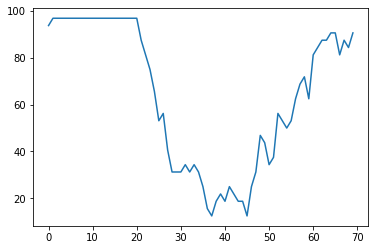

In [197]:
plt.plot(y_test)
# plt.plot(y_pred)

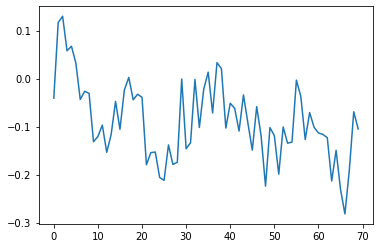

In [198]:
# plt.plot(y_test)
plt.plot(y_pred)

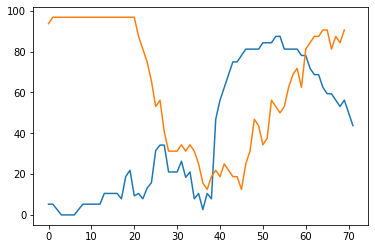

In [199]:
plt.plot(x_train[0,3,:])
plt.plot(y_test[:])

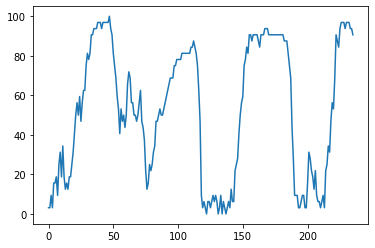

In [172]:
plt.plot(y_train)

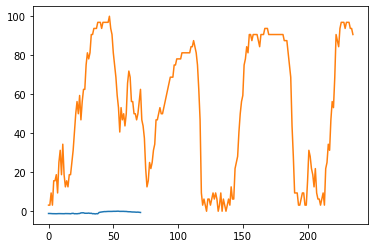

In [174]:
plt.plot(x_train[0,3,:])
plt.plot(y_train[:])

In [212]:

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=7)
])


In [213]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min')
model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

history = model.fit(x_train, y_train, epochs=10,
                      validation_data=[x_test, y_test],
                      callbacks=[early_stopping])

Epoch 1/10
8/8 [==============================] - 1s 48ms/step - loss: 112171.4609 - mean_absolute_error: 273.6758 - val_loss: 17918.8867 - val_mean_absolute_error: 131.9142
Epoch 2/10
8/8 [==============================] - 0s 17ms/step - loss: 54663.1055 - mean_absolute_error: 187.8311 - val_loss: 9973.1807 - val_mean_absolute_error: 97.3327
